# Bioturbation model - calibration using observed data

The bioturbation model relies on an empirical parameter $\beta$, which you may wish to calibrate based on observed data. This notebook shows how you might go about doing that, based on data from this published paper: [Baccaro M, Harrison S, et al 2019](https://doi.org/10.1016/j.envpol.2019.05.106). In this paper, we studied the importance of bioturbation in transporting Ag<sub>2</sub>S nanoparticles (NPs). Full details of this example can be found in the paper.

Say you have the data in [example_data.csv](./example_data.csv), which gives observed concentrations at 7, 14, 21 and 28 days in three soil layers (top, middle, bottom):

In [68]:
import pandas as pd

df = pd.read_csv('./example_data.csv')
df

,day,layer,conc
0,0,top,6.625667
1,0,middle,0.000000
2,0,bottom,0.000000
3,7,top,5.184575
4,7,middle,0.569111
5,7,bottom,0.193135
6,14,top,2.737534
7,14,middle,0.657221
8,14,bottom,0.231144
9,21,top,3.259800


This corresponds to an experimental setup as per the following figure. The three layers where the soil is sample are denoted top, middle and bottom, each of which is 2cm deep. For modelling simplicitly, we conceptualise the soil profile as being six 2-cm layers. 10 mg/kg of Ag<sub>2</sub>S-NPs were added to the top soil layer at day 0.

![Soil profile conceptualisation](../img/calibration-profile.png)

### Creating an optimisable function

We will use SciPy's `leastsq` function to do the optimisation, which involves finding the $\beta$ and initial top layer concentration that best fits the data. To do this, we need to create a cost function to pass to the `leastsq` method. To fit multiple layers at once, we flatten all the layers into one array with a length of number of time steps multiplied by the number of layers.

In [69]:
import bioturbation.model as biom
import numpy as np

def f(params, *args):
    """Function to pass to SciPy to optimise"""
    # Get the calibration parameters
    beta = params[0]
    y_init = params[1]
    # x is the time axis, y is the experimental data, both flattened into a 1D array
    x, y = args[0], args[1]
    # Where to slice the x, y arrays to get individual layers
    n1, n2 = args[2]
    # Config to pass to the bioturbation model
    config = {
        'n_soil_layers': 6,
        'soil_layer_depth': 0.02,                           # m
        'initial_conc': np.array([y_init, 0, 0, 0, 0, 0]),   # mg/kg dry weight
        'earthworm_density': np.full((6,), 9431.0),         # worms/m3
        'beta': beta
    }
    x_obs = (0,7,14,21,28)
    # Run the bioturbation model
    data = biom.run(**config) 
    # Create empty array for the modelled data and populate
    yfit = np.empty(len(x))
    yfit[:n1] = data[0,x_obs]         # Top layer
    yfit[n1:n2] = data[3,x_obs]       # Middle layer
    yfit[n2:] = data[5,x_obs]         # Bottom layer
    # Return the cost as simply the difference between the modelled and observed
    return y - yfit

### Parsing the experimental data

Now let's parse the experimental data imported above into a format that can be used by the model. Use the boolean flag `log_data` to specify whether the optimisation is done using logged data.

In [70]:
y_obs = np.empty((15,))         # Length of 5 time steps * 3 layers
y_obs[:5] = df[df['layer'] == 'top']['conc'].values
y_obs[5:10] = df[df['layer'] == 'middle']['conc'].values
y_obs[10:] = df[df['layer'] == 'bottom']['conc'].values
x_obs = np.array([0, 7, 14, 21, 28] * 3)

### Fitting the data

Now we can pass these data to SciPy, via the function we defined above, to do the fitting.

In [71]:
from scipy.optimize import leastsq

# Initial guess at beta
params0 = [np.array(1e-12), y_obs[0]]
# Obs data
args = (x_obs, y_obs, (5, 10))
# Run the optimisation
results, cov, info, mesg, ier = leastsq(f, params0, args=args, full_output=True)
beta_optimised = results[0]
init_conc_optimised = results[1]
print(f'Optimised beta: {beta_optimised}')
print(f'Optimised initial top layer concentration: {init_conc_optimised}')

# Get the R^2 value of the fit
ss_err = (info['fvec']**2).sum()
ss_tot = ((y_obs - y_obs.mean())**2).sum()
r_squared = 1-(ss_err/ss_tot)
print("R-squared of model fit: {0}".format(r_squared))

Optimised beta: 1.5507295809698396e-12
Optimised initial top layer concentration: 6.889312320894478
R-squared of model fit: 0.9540986748052723


### Plotting the fit

Now we can visually check how good (or bad) the fit is by plotting the observed data against the optimised model.

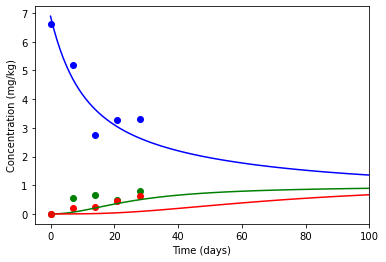

In [72]:
import matplotlib.pyplot as plt

%matplotlib inline

# Plot the experimental data
x_obs = [0, 7, 14, 21, 28]
plt.scatter(x_obs, y_obs[:5], label='Top layer', color='blue')
plt.scatter(x_obs, y_obs[5:10], label='Middle layer', color='green')
plt.scatter(x_obs, y_obs[10:], label='Bottom layer', color='red')

# Rerun the bioturbation model using the calibrated parameters
config = {
    'n_soil_layers': 6,
    'soil_layer_depth': 0.02,
    'initial_conc': np.array([init_conc_optimised, 0, 0, 0, 0, 0]),
    'earthworm_density': np.full((6,), 9431.0),
    'beta': beta_optimised
}
y_calc = biom.run(**config)
x_calc = np.arange(0, y_calc.shape[1])

# Plot the modelled data
plt.plot(x_calc, y_calc[0], color='blue')
plt.plot(x_calc, y_calc[3], color='green')
plt.plot(x_calc, y_calc[5], color='red')

# Finishing up and plotting
plt.xlabel('Time (days)')
plt.ylabel('Concentration (mg/kg)')
plt.xlim(xmin=-5, xmax=100)
plt.show()

This returns a reasonable fit for the top layer, but not so good for the middle and bottom layers. One way of improving this would be to log the data before fitting (see [Baccaro M, Harrison S, et al 2019](https://doi.org/10.1016/j.envpol.2019.05.106)).